In [1]:
import math
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from abc import ABC
from copy import deepcopy
from pyparsing import abstractmethod
from typing import Union, List, Tuple, Literal

-----------
# Base dependencies 


In [2]:
class Vector:
    def __init__(self, vector: np.ndarray):
        
        #it's a column vector
        if (vector.shape[0] > 1) and (vector.shape[1] == 1):
            self.vector = vector
            self.T = vector.T
            self.ndimensions = self.vector.shape[0]
        
        #it's a row vector
        elif (vector.shape[1] > 1) and (vector.shape[0] == 1):
            self.vector = vector.T
            self.T = vector.T
            self.ndimensions = self.vector.shape[0]
        else:
            raise TypeError(f"Should be a row or a column vector, yet has shape: {vector.shape}")

    #================================================
    #            Some important operations
    #================================================

    def calculate_slope(self, vector2: 'Vector') -> float:
        """
            Calculates the slope between self and vector2.

            Input:
                vector2: Vector
            Output:
                slope: float
        """

        if self[0] == vector2[0]:
            return np.inf
        return (self[1] - vector2[1]) / (self[0] - vector2[0])


    def calculate_distance(self, vector2: 'Vector') -> float:
        """
            Calculates the distance between self and vector2.

            Input:
                vector2: Vector
            Output:
                distance: float
        """
        return np.linalg.norm(self.vector - vector2.vector)
    
    def get_furthest_point(self, points: List['Vector']) -> 'Vector':

        """
            Finds the furthest point from self.

            Input:
                points: Vector or List[Vector]
            Output:
                furthest_point: Vector
        """

        # calculate the distance from v0 to each point
        distances = [self.calculate_distance(point) for i, point in enumerate(points)]
        
        # find the maximum distance
        maxdist = max(distances)

        # find the indexes of the points with the maximum distance
        indexes = [i for i, d in enumerate(distances) if d == maxdist]

        return points[indexes[0]]


    @staticmethod
    def calculate_angle(A:'Vector', B:'Vector', C:'Vector') -> Tuple[float, float]:
        """
            Calculates the angle between the vectors AB and BC. This is the same
            as the angle between a walk from A to B and a walk from B to C, and 
            get the angle at the bend.

            Args:
            -----------
                A: Vector
                B: Vector
                C: Vector
            
            Returns:
            -----------
                angle_rad: float
                    Angle in radians
                angle_deg: float
                    Angle in degrees
        """

        AB = B - A
        BC = B - C

        # calculate the cross product between A and B (which are column vectors)
        cross_product = np.cross(AB.vector.T, BC.vector.T)

        # calculate the dot product between A and B (which are column vectors)
        dot_product = np.dot(AB.vector.T, BC.vector)

        # get direction, which is the sign of the cross product and determine if 
        # the angle is convex or concave
        direction = np.sign(cross_product)

        # calculate the angle between A and B, using the cross and dot products
        # with the arctan2 function
        angle_rad = np.arctan2(cross_product, dot_product) + np.pi*direction

        # convert the angle to degrees
        angle_deg = np.degrees(angle_rad)

        #make sure both angles are positive with modular arithmetic
        angle_rad = (angle_rad + 2) % (2)
        angle_deg = (angle_deg + 360) % 360

        return float(angle_rad), float(angle_deg)


    @staticmethod
    def calculate_turn(vector1: 'Vector', vector2: 'Vector', vector3: 'Vector') -> int:

        """
            Calculates if the walk from vector1 to vector2 to vector3 is a left turn
            or a right turn.

            Input:
                vector1: Vector
                vector2: Vector
                vector3: Vector
            Output:
                1: if the walk is a left turn
                -1: if the walk is a right turn
                0: if the points are collinear
        """

        # calculate the cross product between A and B (which are column vectors)
        cross_product = np.cross((vector2 - vector1).vector.T, (vector3 - vector2).vector.T)

        # get direction, which is the sign of the cross product and determine if 
        # the angle is convex or concave
        direction = np.sign(cross_product)

        return int(direction)

    #================================================
    #               Static methods
    #================================================
    @staticmethod
    def get_leftmost_point(points: List['Vector']) -> 'Vector':
        """
            Finds the leftmost point from a list of points.

            Input:
                points: List[Vector]
            Output:
                leftmost_point: Vector
        """
        # find the leftmost point
        leftmost_point = points[0]
        for point in points[1:]:
            if point[0] < leftmost_point[0]:
                leftmost_point = point
        return leftmost_point
    
    @staticmethod
    def get_rightmost_point(points: List['Vector']) -> 'Vector':
        """
            Finds the rightmost point from a list of points.

            Input:
                points: List[Vector]
            Output:
                rightmost_point: Vector
        """
        # find the rightmost point
        rightmost_point = points[0]
        for point in points[1:]:
            if point[0] > rightmost_point[0]:
                rightmost_point = point
        return rightmost_point

    @staticmethod
    def build_random_vectors(nvectors:int, minval = -10, maxval = 10) -> List['Vector']:
        vectors = []
        for i in range(nvectors):
            vectors.append(Vector(np.random.randint(minval, maxval, (2, 1))))

        return vectors
    
    @staticmethod
    def cast_to_vector(*vectors: np.ndarray) -> List['Vector']:
        """
            Casts a list of numpy arrays to a list of column vectors.
        """
        #reshape the vectors to be column vectors
        vectors = [vector.reshape((2, 1)) for vector in vectors]
        return [Vector(vector) for vector in vectors]

    #================================================
    #               Operator overloading
    #================================================
    
    def times_scalar(self, scalar: float) -> 'Vector':
        return Vector(self.vector * scalar)

    def __add__(self, vector2: 'Vector') -> 'Vector':
        return Vector(self.vector + vector2.vector)
    
    def __sub__(self, vector2: 'Vector') -> 'Vector':
        return Vector(self.vector - vector2.vector)
    
    def __mul__(self, other: 'Vector') -> 'Vector':
        if isinstance(other, Vector): 
            return Vector(self.vector * other.vector)
        else: 
            return NotImplemented

    def __rmul__(self, other):
        return self.__mul__(other) 
    
    def __truediv__(self, number: float) -> 'Vector':
        return Vector(self.vector / number)

    def __getitem__(self, index: int) -> float:
        return float(self.vector[index][0])

    def __repr__(self):
        return f"Vec({self.vector[0][0]}, {self.vector[1][0]})"

    def __str__(self):
        return f"Vec({self.vector[0][0]}, {self.vector[1][0]})"

    #================================================
    #              Order relations overloading
    #================================================

    def __eq__(self, vector: 'Vector') -> bool:
        return (self[0] == vector[0]) and (self[1] == vector[1])

    def __ne__(self, vector: 'Vector') -> bool:
        return (self[0] != vector[0]) or (self[1] != vector[1])

    def __lt__(self, vector2: 'Vector') -> bool:
        return (self[1] > vector2[1]) or (self[1] == vector2[1] and self[0] < vector2[0])

    def __gt__(self, vector2: 'Vector') -> bool:
        return (self[1] < vector2[1]) or (self[1] == vector2[1] and self[0] > vector2[0])
    
    def __ge__(self, vector2: 'Vector') -> bool:
        return (self > vector2) or (self == vector2)
    
    def __le__(self, vector2: 'Vector') -> bool:
        return (self < vector2) or (self == vector2)
    
    def __hash__(self):
        return hash((self[0], self[1]))


In [3]:
class Segment():

    def __init__(self, start: Vector, end: Vector, sort_ends = False) -> None:
        """
            This class is used to represent a segment in 2D space.
            start and end are the vertices of the segment. Starting from start, and ending in end.
        """
        self.start = start
        self.end = end

        #make sure that the start is the lowest leftmost point, 
        #refer to our order operator overload in vector.py
        if sort_ends and (self.start > self.end):
            self.start, self.end = self.end, self.start


    def get_midpoint(self) -> Vector:
        """
            Calculates the midpoint of the segment.
        """
        return (self.start + self.end)/2

    def calcutale_slope(self) -> float:
        """
            Calculates the slope of segment.
        """
        deltas = self.end - self.start

        if deltas[0] == 0:
            return np.inf

        return (deltas[1])/(deltas[0])
        
    def calculate_distance(self) -> float:
        """
            Calculates the distance between end and v2.
        """
        return np.linalg.norm(self.end - self.start)

    
    def on_segment(self, v3: Vector) -> bool:
        """
            Checks if v3 is on the segment startend area,
            this area is defined by the rectangle with vertices start and end.
        """
        inx = min(self.start[0], self.end[0]) <= v3[0] <= max(self.start[0], self.end[0]) 
        iny = min(self.start[1], self.end[1]) <= v3[1] <= max(self.start[1], self.end[1])

        if (inx and iny):
            return True
        return False

    def direction(self, vector3: Vector) -> int:
        """
            Given our segment, and a vector3, determine if vector3 is rotated clockwise or anticlockwise, 
            or if they are colineal, with respect to the segment.
        """
        det = np.linalg.det(np.column_stack([(vector3 - self.start).vector, (self.end - self.start).vector]))

        if det < 0:
            return -1
        elif det > 0:
            return 1
        return 0

    def segments_intersect(self, other_segment: 'Segment') -> bool:

        """
            Given one segment, determine if the segments they form intersect.
            Segments are startend from self, and startend from other_segment.
        """

        #directions with respect to other_segment
        dir1 = other_segment.direction(self.start)
        dir2 = other_segment.direction(self.end)
        
        #directions with respect to self
        dir3 = self.direction(other_segment.start)
        dir4 = self.direction(other_segment.end)

        #well behaved case
        if (dir1*dir2 < 0) and (dir3*dir4 < 0):
            return True
    
        #collinear case with respect to other_segment
        elif (dir1 == 0) and (other_segment.on_segment(self.start)):
            return True

        elif (dir2 == 0) and (other_segment.on_segment(self.end)):
            return True

        #collinear case with respect to self
        elif (dir3 == 0) and (self.on_segment(self.start)):
            return True

        elif (dir4 == 0) and (self.on_segment(self.end)):
            return True
        
        else:
            return False
    
    def get_intersection_of_segments_general(self, other_segment: 'Segment') -> Union['Segment', Vector]:

        """
            This method uses the find_intersection_on_endpoints, 
            the find_intersection, and the find_interval_intersection methods,
            which respectively get the intersect on endpoints (if any),
            the intersection between segments (if any), 
            and the intersection on an interval (if any).
        """
    
        # Find the intersection point (if any)
        intersection = self.find_intersection(other_segment)

        # Find the intersection on endpoints (if any)
        intersection_on_endpoints = self.find_intersection_on_endpoints(other_segment)

        # Find the intersection on segments (if any)
        intersection_on_segments = self.find_interval_intersection(other_segment)

        if intersection_on_segments is not None:
            return intersection_on_segments
        elif intersection_on_endpoints is not None:
            return intersection_on_endpoints
        else:
            return intersection


    
    def find_intersection_on_endpoints(self, other_segment: 'Segment') -> Union['Segment', None]:
        """
            Finds the intersection of the segments on the endpoints.
        """
        if (self.start == other_segment.start) or (self.start == other_segment.end):
            return self.start
        elif (self.end == other_segment.start) or (self.end == other_segment.end):
            return self.end
        else:
            return None
    
    def find_intersection(self, other_segment: 'Segment') -> Vector:
        """
            Finds the intersection of the lines formed by the segments endv2 and v3v4.
        """

        difference1 = (self.start - self.end).vector
        difference2 = (other_segment.start - other_segment.end).vector
        result = (other_segment.start - self.end).vector

        matrix = np.column_stack([difference1, difference2])
        
        #if the matrix is singular, then the lines are parallel, 
        # but they might intersect on the endpoints
        try:
            alpha_beta = np.linalg.solve(matrix, result).reshape(2,)

        except np.linalg.LinAlgError as e:
            if 'Singular matrix' in str(e):
                return self.find_intersection_on_endpoints(other_segment)
            else: 
                raise e
            
        intersect = self.start.times_scalar(alpha_beta[0]) + self.end.times_scalar(float(1 - alpha_beta[0]))

        return intersect
    
    def find_interval_intersection(self, other_segment: 'Segment') -> Union['Segment', None]:
        """
            Finds the interval intersection of the segments.
            If there is no intersection, return None.
        """

        #check if the segments have the same slope
        same_slope = self.calcutale_slope() == other_segment.calcutale_slope()

        # given that they have the same slope, check one of the 
        # segments is contained in the other, we do this by taking the endpoints of the segments
        # and checking if they are contained in the other segment
        p0_on_segment = other_segment.on_segment(self.start)
        p1_on_segment = other_segment.on_segment(self.end)
        p2_on_segment = self.on_segment(other_segment.start)
        p3_on_segment = self.on_segment(other_segment.end)
        ans = None

        if same_slope:
            if (p0_on_segment and p1_on_segment):
                ans =  Segment(self.start, self.end)
            elif (p2_on_segment and p3_on_segment):
                ans = Segment(other_segment.start, other_segment.end)
            elif (p0_on_segment and p3_on_segment):
                ans = Segment(self.start, other_segment.end)
            elif (p2_on_segment and p1_on_segment):
                ans = Segment(other_segment.start, self.end)
            else:
                return ans
        else:
            return ans

        #there could be a posibility that it matches as a segment
        #something that it's indeed a point
        if ans.start == ans.end:
            return None 
        else:
            return ans

    @staticmethod
    def build_random_segments(nsegments: int=10)-> List['Segment']:
        """
            Builds nsegments random segments.
        """
        segments = []

        for _ in range(nsegments):
            start = Vector.build_random_vectors(1)[0]
            end = Vector.build_random_vectors(1)[0]
            segments.append(Segment(start, end))

        return segments

    def __repr__(self) -> str:
        return f"Segment({self.start}, {self.end})"
    
    def __eq__(self, other_segment: 'Segment') -> bool:

        if (self is not None and other_segment is None) or (self is None and other_segment is not None):
            return False

        self_set = set([self.start, self.end])
        other_set = set([other_segment.start, other_segment.end])
        return self_set == other_set
        
    def __ne__(self, other_segment: 'Segment') -> bool:
        return not self.__eq__(other_segment)
    
    def __hash__(self):
        return hash((self.start, self.end))

------------
# Semiedge list related dependencies


In [4]:
class GeometricNode():
    """
        This class represents a node in a double connected edge list.
    """

    def __init__(self,
                 point: Vector,
                 name: str = None, 
                 incident_edge: Segment = None,):

        """
            Every node name is a string that represents the name of the node, and
            should have a format like this: 'N1', 'N2', 'N3', etc.
        """
        self.name = name
        self.value = None
        self.point = point
        self.incident_edge = incident_edge

    def __getitem__(self, index: int) -> float:
        return float(self.point[index])
    
    def __repr__(self) -> str:
        return f"{self.name} {self.point}"

    def __eq__(self, other_node: 'GeometricNode') -> bool:
        return self.point == other_node.point
    
    def __ne__(self, other_node: 'GeometricNode') -> bool:
        return self.point != other_node.point

In [5]:
class Face():
    
    INTERIOR_FACE = 1
    EXTERIOR_FACE = 2 

    def __init__(self, name: str = None):

        self.semi_edges: List['SemiEdge'] = []
        self._name: str = name
        self.face_type: int = -1
    
    @property
    def name(self) -> str:
        return self._name
    
    def set_name(self, name: str) -> None:
        self._name = name

    def set_semi_edges(self, semi_edges: List['SemiEdge']) -> None:
        self.semi_edges = semi_edges
        self.set_face_type()

    def add_semi_edge(self, semi_edge: 'SemiEdge') -> None:
        self.semi_edges.append(semi_edge)
    
    def set_face_type(self):
        
        #get the leftmost point among the set of points in the polygon
        points = [semiedge.origin.point for semiedge in self.semi_edges]
        left_most_point = Vector.get_leftmost_point(points)
        
        #get the index corresponding to the segment that has that point as 
        #orgin
        idx = points.index(left_most_point)
        left_most_semiedge = self.semi_edges[idx]

        #get the origin point, the previous and the next of these
        origin = left_most_semiedge.start
        prev = left_most_semiedge.prev_edge.start
        next_ = left_most_semiedge.end

        #get the way the face is turning 
        turn = Vector.calculate_turn(prev, origin, next_)

        if turn == 1:
            self.face_type = Face.EXTERIOR_FACE
        elif turn == -1:
            self.face_type = Face.INTERIOR_FACE

    def __str__(self) -> str:
        return f"{self._name}"
    
    def __repr__(self) -> str:
        return f"{self._name}"

_Here we can find the critical code to the task at hand of today, inserting correctly an edge into an already formed polygon. The main process is executed in the SemiEdgeList Class under the method_ ***add_new_edge***.

In [6]:
class SemiEdge():

    def __init__ (self, 
                  origin: Union[GeometricNode, Vector],
                  next_: Union[GeometricNode, Vector],
                  incident_face: Face = None, 
                  need_cast: bool = False):


        if need_cast:
            self.origin: GeometricNode = GeometricNode(origin)
            self.next_: GeometricNode = GeometricNode(next_)

        else:
            self.origin: GeometricNode = origin
            self.next_: GeometricNode = next_

        self.seg: Segment = Segment(self.origin.point, self.next_.point)
        self.incident_face: Face = incident_face

        #completely twisted version of self
        self.next_edge: SemiEdge = None
        self.prev_edge: SemiEdge = None
        self.twin: SemiEdge = None
        
        #name of the semiedge
        self.name: str = None
        
        # This is used for the triangulation, the literal part is a constant 
        # that indicates the helper vector type, this could be START_VERTEX,
        # END_VERTEX, SPLIT_VERTEX, MERGE_VERTEX, REGULAR_VERTEX
        self.helper: Tuple[Vector, Literal]= None
    
    @property
    def start(self) -> Vector:
        return self.seg.start
    
    @property
    def end(self) -> Vector:
        return self.seg.end

    def set_next_edge(self, next_edge: 'SemiEdge') -> None:
        self.next_edge = next_edge
    
    def set_prev_edge(self, prev_edge: 'SemiEdge') -> None:
        self.prev_edge = prev_edge
    
    def set_helper(self, helper: Tuple[Vector, int]) -> None:
        self.helper = helper

    def set_twin(self, twin: 'SemiEdge') -> None:
        self.twin = twin
    
    def set_name(self, name: str) -> None:
        self.name = name

    def __repr__(self) -> str:
        #return f"{self.name} SemiEdge({self.origin.name},{self.next_.name}) {self.incident_face}"
        return f"{self.name}"
    
    def __str__(self) -> str:
        #return f"{self.name} SemiEdge({self.origin.name},{self.next_.name}) {self.incident_face}"
        return f"{self.name}"
    
    def __eq__(self, semiedge: 'SemiEdge') -> bool:
        return self.seg == semiedge.seg 
        
    def __ne__(self, semiedge: 'SemiEdge') -> bool:
        return self.seg != semiedge.seg

#------------------------------------------------------------------------------#
class SemiEdgeList():

    def __init__(self, list_of_points: List[Vector], name: str):
        
        self.list_of_nodes : List[GeometricNode] = []
        self.semi_edges : List[SemiEdge] = []
        self.faces : List[Face] = []
        self.name = name
        
        self._build_nodes(list_of_points)
        self._build_semi_edges()
    
    def show_data_structure(self) -> pd.DataFrame:
        df = pd.DataFrame(columns = ["name", "origin", "next", "prev_edge", "next_edge", "twin", "prev_edge_twin", "next_edge_twin", "incident_face"])

        for semiedge in self.semi_edges:
            line = pd.DataFrame([{"name": semiedge.name,
                                  "origin": semiedge.origin.name, 
                                  "next": semiedge.next_.name, 
                                  "prev_edge": semiedge.prev_edge, 
                                  "next_edge": semiedge.next_edge,
                                  "twin": semiedge.twin, 
                                  "prev_edge_twin": semiedge.twin.prev_edge,
                                  "next_edge_twin": semiedge.twin.next_edge,
                                  "incident_face": semiedge.incident_face.name},])
            df = pd.concat([df, line])

        df = df.reset_index(drop=True)

        return df

    def add_new_semi_edges(self, semi_edges: List[SemiEdge]) -> None:
        """
            This function adds semi-edges to the list of semi-edges.

            This is a delicate process, because with each semi-edge we add 
            it's necessary to add the next and prev edges of each semi-edge.
            And if this semiedge intersects with another semi-edge, we have to
            add the intersection point to the list of nodes, and add the new
            semi-edges that are created by the intersection.
        """
        
        for semiedge in semi_edges:
            self.add_new_edge(semiedge)

    def _build_nodes(self, list_of_points: List[Vector]) -> None:
        """
            This function builds the nodes from a list of points.
            The name of each node is the index of the point in the list of points.
        """
        self.list_of_nodes = []
        for i in range(len(list_of_points)):
            node = GeometricNode(point = list_of_points[i], name = f"{self.name}N{i}")
            self.list_of_nodes.append(node)

    def _build_semi_edges(self) -> List[SemiEdge]:
        """
            This function builds the semi-edges from the list of nodes.
            This assumes that the list of nodes is ordered in a way that
            the next node is the next node in the polygon (this is true just 
            at first build time).

            The function builds the semi-edges, the next and prev edges of each
            semi-edge, and the faces of each semi-edge.
        """
        self.semi_edges = []
        
        # Create the semi-edges from the list of nodes
        for i in range(len(self.list_of_nodes)):
            semi_edge = SemiEdge(origin = self.list_of_nodes[i], 
                                 next_ = self.list_of_nodes[(i+1)%len(self.list_of_nodes)])
            twin = SemiEdge(origin = semi_edge.next_, 
                            next_ = semi_edge.origin)

            #handle twins mutually
            semi_edge.set_twin(twin)
            twin.set_twin(semi_edge)

            #add to the list of semi-edges, and set the name
            semi_edge.set_name(f"SE{len(self.semi_edges)}")
            twin.set_name(f"SE{len(self.semi_edges)}''")
            self.semi_edges.append(semi_edge)

        # Set the next and prev edges of each semi-edge
        for i in range(len(self.semi_edges)):
            self.semi_edges[i].set_next_edge(self.semi_edges[(i+1)%len(self.semi_edges)])
            self.semi_edges[i].set_prev_edge(self.semi_edges[(i-1)%len(self.semi_edges)])

            twin_next = SemiEdge(origin = self.semi_edges[i].prev_edge.next_,
                                 next_ = self.semi_edges[i].prev_edge.origin)
            twin_prev = SemiEdge(origin = self.semi_edges[i].next_edge.next_,
                                 next_ = self.semi_edges[i].next_edge.origin)

            twin_next.set_name(f"{self.semi_edges[i].prev_edge.name}''")
            twin_prev.set_name(f"{self.semi_edges[i].next_edge.name}''")

            self.semi_edges[i].twin.set_next_edge(twin_next)
            self.semi_edges[i].twin.set_prev_edge(twin_prev)
        
        # add faces to the semi-edges
        self._set_faces(self.semi_edges)

        return self.semi_edges

    def _set_faces(self, edges: List[SemiEdge]) -> None:
        """
            This function adds the faces to the semi-edges.

            The idea is to take a semi-edge, and iter to the next semi-edge until
            we reach the initial semi-edge. All the semi-edges that we visited until 
            reaching the initial semi-edge form a face.
        """

        faces_count = 0

        # We iterate over the semi-edges
        for semi_edge in edges:

            #print(f"iterating over semi-edge {semi_edge}, face: {semi_edge.incident_face}, face_count: {faces_count}")
            # If the semi-edge doesn't have a face, then we add a face
            if semi_edge.incident_face == None:
                # We create a new face
                face = Face(name = f"{self.name}:F{faces_count}")

                # We add the semi-edge to the face
                face.add_semi_edge(semi_edge)
                # We iterate over the next semi-edge
                next_semi_edge = semi_edge.next_edge
                # We add the face to the semi-edge
                semi_edge.incident_face = face
                next_semi_edge.incident_face = face

                # While the next semi-edge is not the initial semi-edge
                while next_semi_edge != semi_edge:
                    #print(f"\t next_semi_edge: {next_semi_edge}, semi_edge: {semi_edge}, face: {face}, face_count: {faces_count}")

                    # We iterate over the next semi-edge
                    next_semi_edge = next_semi_edge.next_edge

                    # We add the face to the semi-edge
                    next_semi_edge.incident_face = face

                face.set_face_type()
                self.faces.append(face)
                faces_count += 1

    def add_new_edge(self, semiedge: SemiEdge) -> None:

        twin = SemiEdge(origin = semiedge.next_,
                        next_  = semiedge.origin)

        #add the twin and semiedge name 
        semiedge.set_name(f"SE{len(self.semi_edges)}")
        twin.set_name(f"SE{len(self.semi_edges)}''")

        #identify the semiedges with origin in any of the ends 
        #of the semiedge I want to add

        #print(f"I want to add {semiedge}")
        related_edges_orig = self.get_incident_edges_of_vertex(semiedge.origin)
        related_edges_next = self.get_incident_edges_of_vertex(semiedge.next_)

        #from those related edges filter the ones that have the same incident face and 
        #that are exterior frontier 
        related_edges_orig = [e for e in related_edges_orig if e.incident_face.face_type == Face.EXTERIOR_FACE]
        related_edges_next = [e for e in related_edges_next if e.incident_face.face_type == Face.EXTERIOR_FACE]

        related_edges = related_edges_orig + related_edges_next
        found = False
        pair: Tuple[SemiEdge, SemiEdge] = ()
        #print(f"RELATED EDGES {related_edges}")

        #search the pair that has the same incident face
        for e1 in related_edges:
            for e2 in related_edges:

                if (e1.incident_face == e2.incident_face) and (e1 != e2):
                    pair = (e1, e2)
                    found = True
                    break
            if found:
                break
        
        related_a = pair[0] if pair[0].origin == semiedge.origin else pair[1]
        related_b = pair[1] if related_a == pair[0] else pair[0]
        
        #reset prev edge of existent edges in the polygon
        related_a.prev_edge.set_next_edge(semiedge)
        related_b.prev_edge.set_next_edge(twin)

        #set the previous edges of the new semiedges
        semiedge.set_prev_edge( related_a.prev_edge )
        twin.set_prev_edge( related_b.prev_edge )

        #set the next edges of the new semiedges 
        semiedge.set_next_edge( related_b )
        twin.set_next_edge( related_a )

        #reset the prev edge of the existent edges in polygon
        related_b.set_prev_edge(semiedge) 
        related_a.set_prev_edge(twin)   

        semiedge.twin = twin
        self.semi_edges.append(semiedge)
        
        #set origin and next vertex names
        semiedge.origin.name = related_edges_orig[0].origin.name
        semiedge.next_.name = related_edges_next[0].origin.name
        twin.origin.name = related_edges_next[0].origin.name
        twin.next_.name = related_edges_orig[0].origin.name

        #reset the faces of the polygon
        self._reset_faces()

    def get_incident_edges_of_vertex(self, vertex: GeometricNode) -> List[SemiEdge]:

        starts_at_vertex = []

        for semiedge in self.semi_edges:
            if semiedge.origin == vertex:
                starts_at_vertex.append(semiedge)

        return starts_at_vertex

    def _reset_faces(self):
        self.faces = []

        for s in self.semi_edges:
            #remove the face from memory
            del s.incident_face
            del s.twin.incident_face

            #remove the face from attributes
            s.incident_face = None
            s.twin.incident_face = None
        
        self._set_faces(self.semi_edges)

    def __getitem__(self, index: int) -> SemiEdge:
        return self.semi_edges[index]

    def __len__(self) -> int:
        return len(self.semi_edges)
    
    def __iter__(self):
        return iter(self.semi_edges)

    def __str__(self) -> str:
        return f"{self.semi_edges}"
    
    def __repr__(self) -> str:
        return f"{self.semi_edges}"

---------
# Status tree related dependencies

In [7]:
class Node(ABC):

    def __init__(self, value):
        self.value = value
        self.left = None
        self.right = None
        self.extra = None

    def __repr__(self):
        return f"Node({self.value})"

    #classes inheriting from this class must implement these methods
    @abstractmethod
    def __gt__(self, other):
        raise NotImplementedError
    
    @abstractmethod
    def __lt__(self, other):
        raise NotImplementedError
    
    @abstractmethod
    def __eq__(self, other):
        raise NotImplementedError
    
    @abstractmethod
    def __ge__(self, other):
        raise NotImplementedError
    
    @abstractmethod
    def __le__(self, other):
        raise NotImplementedError
    
    @staticmethod
    def cast_to_nodes(values: List) -> List['Node']:
        raise NotImplementedError


class Node1D(Node):

    def __init__(self, value: int):
        self.value = value
        self.left = None
        self.right = None
        
        #extra attribute to store something useful
        #like a segment, a point, etc.
        self.extra = None

    #=====================================
    #       order comparison methods
    #=====================================
    def __gt__(self, other: 'Node1D'):
        return self.value > other.value

    def __lt__(self, other: 'Node1D'):
        return self.value < other.value

    def __eq__(self, other: 'Node1D'):
        return self.value == other.value

    def __ge__(self, other: 'Node1D'):
        return self.value >= other.value
    
    def __le__(self, other: 'Node1D'):
        return self.value <= other.value

    @staticmethod
    def cast_to_nodes(values: List[float]) -> List['Node1D']:
        return [Node1D(v) for v in values]


class Node2D(Node):
    
        def __init__(self, value: tuple):
            """
                Creates a node with a value of 2 elements.

                value: tuple of 2 elements, where the first element is the x coordinate 
                and the second element is the y coordinate.
            """

            self.value = value
            self.left = None
            self.right = None
    
        #=====================================
        #       order comparison methods
        #=====================================
        def __gt__(self, other: 'Node2D'):
            if self.value[1] > other.value[1]:
                return True
            elif self.value[1] == other.value[1]:
                return self.value[0] < other.value[0]
    
        def __lt__(self, other: 'Node2D'):
            
            if self.value[1] > other.value[1]:
                return True
            elif self.value[1] == other.value[1]:
                return self.value[0] > other.value[0]
    
        def __eq__(self, other: 'Node2D'):
            return self.value == other.value
    
        def __ge__(self, other: 'Node2D'):
            return (self > other) or (self == other)
        
        def __le__(self, other: 'Node2D'):
            return (self < other) or (self == other)
    
        @staticmethod
        def cast_to_nodes(values: List[float]) -> List['Node2D']:
            return [Node2D(v) for v in values]

In [8]:
class Tree():

    def __init__(self,
                 values: List[Union[float, Node1D, Node2D]],
                 sorted: bool = False, 
                 dimension: int = 1, 
                 need_cast: bool = False):

        """
            Builds a tree from a list of values.

            Args:
            --------------
                values: list of values to be inserted in the tree.
                sorted: if the values are already sorted.
                dimension: dimension of the values. It can be 1 or 2.
                need_cast: if the values are not nodes, cast them to nodes.
            
            Returns:
            --------------
                tree: the tree.
        """

        if dimension == 1:
            #if the values are not nodes, cast them to nodes
            if need_cast:
                self.list_of_nodes = Node1D.cast_to_nodes(values)
            else:
                self.list_of_nodes = values
            
        elif dimension == 2:
            #if the values are not nodes, cast them to nodes
            if need_cast:
                self.list_of_nodes = Node2D.cast_to_nodes(values)
            else:
                self.list_of_nodes = values

        else:
            raise ValueError("dimension must be 1 or 2")

        self.root = None
        self.sorted = sorted
        self.dimension = dimension

        if not sorted:
            self.build()

    def build(self) -> None:
        """
            Builds the tree from the list of nodes.
        """
        self.root = self.list_of_nodes[0]
        
        #adds all the nodes
        for child in self.list_of_nodes[1:]:
            Tree.normal_insert(self.root, child)

    def inorder(self) -> List[Union[Node1D, Node2D]]:

        """
            Reads the tree in inorder.
            and returns the list of Nodes in ascending order, following 
            the order overloads of the Node class.
        """
        return Tree.inorder_recursion(self.root)

    def insert(self, node: Union[Node1D, Node2D]) -> None:
        """
            Inserts a node in the tree.
        """
        Tree.normal_insert(self.root, node)
    
    def build_from_sorted_list(self, sorted_list: List[Union[Node1D, Node2D]])-> 'Tree':

        """
            Inserts the values from an ordered list.
            This is a more efficient way to build a tree.
        """
        root = Tree.build_from_sorted_list_recursion(sorted_list)

        #builds the new tree
        tree = Tree(sorted_list, sorted=True, dimension=self.dimension)
        tree.root = root

        return tree

    @staticmethod
    def build_from_sorted_list_recursion(sorted_list: list) -> Union[Node1D, Node2D]:
        """
            Inserts the values from an ordered list, in ascending order.
        """
        
        if len(sorted_list) == 0:
            return None
        
        middle = int(len(sorted_list)/2) #it's ok for both, even and odd lenght because python starts counting at 0
        root = sorted_list[middle]

        root.left = Tree.build_from_sorted_list_recursion(sorted_list[:middle])
        root.right = Tree.build_from_sorted_list_recursion(sorted_list[middle+1:])

        return root
        
        
    @staticmethod
    def inorder_recursion(root: Node) -> List[Union[Node1D, Node2D]]:
        """
            Reads the tree in inorder.
            and returns the list of Nodes in ascending order, following 
            the order overloads of the Node class.
        """

        if root is None:
            return []

        if root.left is None and root.right is None:
            return [root,]

        return Tree.inorder_recursion(root.left) + [root,] + Tree.inorder_recursion(root.right)
    

    @staticmethod
    def normal_insert(root: Node, child: Node) -> None:
        
        if root is None:
            return
        
        #if the child is greater than the root, it goes to the right
        if (root < child):
            
            if root.right is None:
                root.right = child
            else:
                Tree.normal_insert(root.right, child)

        #if the child is less than or equal to the root, it goes to the left
        elif (root >= child):
            if root.left is None:
                root.left = child
            else:
                Tree.normal_insert(root.left, child)


For the task at hand is not necesary to get the y-monotone version of a polygon, but for plotting convenience and 
because it was already done, i'm going to use this as help for finding a diagonal to add.

----------------------------
# Main algorithm of turning a given Polygon into a y-monotone one


In [ ]:
REGULAR_VERTEX = 0
START_VERTEX = 1
MERGE_VERTEX = 2
SPLIT_VERTEX = 3
END_VERTEX = 4

In [15]:
class PlotMonotonePolygon():


    def __init__(self):
        pass

    @staticmethod
    def plot_polygon(semiedges: SemiEdgeList,
                     color: str = 'black',
                     linewidth: float = 1.0,
                     alpha: float = 1.0,
                     s: float = 40,
                     classifications: List[Tuple[Vector, SemiEdge, str]] = None) -> None:

        for semiedge in semiedges:
            plt.plot([semiedge.seg.start[0], semiedge.seg.end[0]],
                     [semiedge.seg.start[1], semiedge.seg.end[1]],
                      color=color,
                      linewidth=linewidth,
                      alpha=alpha)
        
        for vec, semiedge, classification in classifications:

            # normal black point if it's a regular vertex
            if classification == REGULAR_VERTEX:
                plt.scatter(vec[0], vec[1], color='black', s=s, alpha=3*alpha/4)
            
            # empty square if it's a start vertex, on yellow
            elif classification == START_VERTEX:
                plt.scatter(vec[0], vec[1], color='black', s=s, marker='P', alpha=alpha)
            
            # filled square if it's a end vertex, on orange
            elif classification == END_VERTEX:
                plt.scatter(vec[0], vec[1], color='black', s=s, marker='X', alpha=alpha)
            
            # triangle pointing up if it's a split vertex, on green
            elif classification == SPLIT_VERTEX:
                plt.scatter(vec[0], vec[1], color='green', s=s, marker='^', alpha=alpha)
            
            # triangle pointing down if it's a merge vertex, on red
            elif classification == MERGE_VERTEX:
                plt.scatter(vec[0], vec[1], color='red', s=s, marker='v', alpha=alpha)
        

    @staticmethod
    def show() -> None:
        plt.show()

class PlotDoubleConnectedEdgeList():

    def __init__(self) -> None:
        pass

    @staticmethod
    def plot(semiedges: SemiEdgeList,
             color: str = 'black',
             linewidth: float = 1.0,
             alpha: float = 1.0) -> None:

        #a plot for each semi-edge, it's an arrow from the start to the end
        #of the semi-edge, dashed line, also plotting the twin of this semi-edge
        #a little bit to the left and with less alpha
        for semiedge in semiedges:
            
            dx = semiedge.end[0] - semiedge.start[0]
            dy = semiedge.end[1] - semiedge.start[1]
            dxtwin = semiedge.twin.end[0] - semiedge.twin.start[0]
            dytwin = semiedge.twin.end[1] - semiedge.twin.start[1]
            offset = 0.05
            
            plt.arrow(semiedge.start[0], semiedge.start[1],
                      dx, dy,
                      color = color, linewidth = linewidth, alpha = alpha,
                      length_includes_head = True, head_width = 0.1)
            
            #a little bit to the left and with half the alpha, dashed line
            plt.arrow(semiedge.twin.start[0]+offset, semiedge.twin.start[1],
                      dxtwin+offset, dytwin,
                      color = 'red', linewidth = linewidth, alpha = alpha/3,
                      length_includes_head = True, head_width = 0.1, linestyle = '--')

            #add name of the vextex to the plot
            plt.text(semiedge.start[0],
                     semiedge.start[1]+2*offset,
                     semiedge.origin.name,
                     fontsize = 10)

    @staticmethod
    def show() -> None:
        plt.show()
        


In [10]:
class SweepLineMonotonePoly:

    def __init__(self, semiedges: SemiEdgeList, epsilon: float = 1e-5):

        """
            Implement use sweepline abstraction to Make any polygon a monotone polygon.

            Args:
                segments: list of segments to be processed.
        """

        self.semiedges = deepcopy(semiedges)
        self.epsilon  = epsilon
        self.status_tree : Tree[Node1D]   = None 
        self.event_points : List[Vector]  = None 
        self.sorted_status : List[Node1D] = None 
        self.diagonals : List[SemiEdge] = [] 

        #to keep track of the number of event points processed
        self.count: int = 0
        
        #to ensure that we do not add a semiedge that has already been removed
        self.removed_semiedges: List[SemiEdge] = []

        #to set the sweepline width in the x axis
        self.leftmost_endpoint : Vector  = None 
        self.rightmost_endpoint : Vector = None 

        #to keep track of the event points
        self.sweep_line : Segment = None 

    def update_sweepline(self, y, type_: str) -> None:

        """
            Update the sweepline to the height y. 
            If type_ is "intersection" then we update the sweepline to the height y - epsilon, 
            which is equivalent to check a little bit below the intersection.
            Otherwise we update the sweepline to the height y.
            
            Args:
            -----------
                y: height of the sweepline.
                type_: type of endpoint, whether it's a start, end (vertex) 
                or intersection endpoint (intersection).
        """

        xleft = self.leftmost_endpoint[0] - 1
        xright = self.rightmost_endpoint[0] + 1

        if type_ == "intersection":
            y = y - self.epsilon

        # build the sweepline, from leftmost to rightmost points in the x axis
        # at height y, and tilt a little bit on the right end of the sweepline
        # in order to avoid problematic behavior with horizontal segments.
        self.sweep_line = Segment(Vector(np.array([[xleft], [y]])), Vector(np.array([[xright], [y + self.epsilon]])))

    def update_status_tree(self) -> None:
        """
            And update the nodes positions in the status tree, by the x coordinate of the intersection
            of the segment with the sweepline.
        """

        in_order_tree = self.status_tree.inorder()
        updated_nodes = []

        # update the status tree
        # for each node in the status tree, we update the intersection with the sweepline
        for node in in_order_tree:
            node.value = self.sweep_line.find_intersection(node.extra)[0]
            
            #reset the left and right childs
            node.left = None
            node.right = None
            updated_nodes.append(node)
        
        # rebuild the status tree
        if len(updated_nodes) > 0:
            self.status_tree = Tree(updated_nodes)
            self.sorted_status = self.status_tree.inorder() 


    def sort_and_classify_endpoints(self) -> List[Tuple[Vector, SemiEdge, str]]:

        """
            Sort the endpoints of the segments, and classify them as one of the following:
                - regular vertex
                - start vertex
                - end vertex
                - split vertex
                - merge vertex

            Returns:
            -----------
                A list of tuples, where each tuple contains the endpoint, the semiedge that contains the endpoint as 
                origin, and the type of endpoint.
        """
        endpoints = []

        for i in range(len(self.semiedges)):
            semiedge = self.semiedges[i]
            prev_semiedge = self.semiedges[i - 1]
            origin = semiedge.origin

            # classify the vertex
            type_ = self.classify_vertex(origin.point, semiedge, prev_semiedge)
            endpoints.append((origin.point, semiedge, type_))
            
        # sort by using the vector own comparison methods
        endpoints.sort(key=lambda endpoint_tuple: endpoint_tuple[0])
        return endpoints

    

    def classify_vertex(self, vertex: Vector, semiedge: SemiEdge, prev_semiedge: SemiEdge) -> int:
            
        """
            Classify a vertex as one of the following:
                - regular vertex
                - start vertex
                - end vertex
                - split vertex
                - merge vertex

            Args:
                vertex: vertex to be classified.
                semiedge: semiedge that contains the vertex, as the origin.
                prev_semiedge: previous semiedge in the list of semiedges.
            
            Returns:
                vertex type: int
        """

        # get previous and next points of the vertex
        prev_point = prev_semiedge.origin.point
        next_point = semiedge.next_.point
        turn = Vector.calculate_turn(prev_point, vertex, next_point)

        # the neighbors of the vertex are below the vertex
        if (vertex < prev_point) and (vertex < next_point):

            #if the angle between prev_point, vertex and next_point is less than 180 degrees
            #then the vertex is a start vertex, this is the same as saying that the turn is 1
            #(clockwise turn)
            if turn == 1:
                return START_VERTEX
            else:
                return SPLIT_VERTEX
            
        # the neighbors of the vertex are above the vertex
        elif (vertex > prev_point) and (vertex > next_point):

            #if the angle between prev_point, vertex and next_point is less than 180 degrees
            #then the vertex is a end vertex, this is the same as saying that the turn is 1
            #(clockwise turn)
            if turn == 1:
                return END_VERTEX
            else:
                return MERGE_VERTEX
            
        # the neighbors of the vertex are on the same line as the vertex
        # or one is above and the other is below the vertex
        else:
            return REGULAR_VERTEX



    def add_to_status_tree(self, semiedge: SemiEdge) -> Node1D:

        """
            Add a semiedge to the status tree.
            Wraps a semiedge with a Node1D element and adds it to the tree.
        """
        
        # update the sorted status before adding the semiedge
        if self.status_tree is not None:
            self.sorted_status = self.status_tree.inorder()
        
        #do not add the semiedge if it has already been removed
        if semiedge in self.removed_semiedges:
            return 

        if (self.status_tree is None) or (len(self.sorted_status) == 0):
            # we insert the segment in the status tree, by using the intersection with the sweepline
            # as the value for the node. In this case as there are no other segments in the status 
            # tree we just insert by the xcoordinate of the start point of the segment.
            n = Node1D(semiedge.seg.start[0])
            n.extra = semiedge
            self.status_tree = Tree([n,])
            self.sorted_status = [n,]
        else:
            # if there is an status tree, we need to find the intersection of the segment with the
            # sweepline, and insert the segment in the status tree by the xcoordinate of the
            # intersection.
            intersectx = semiedge.seg.find_intersection(self.sweep_line)[0]
            n = Node1D(intersectx)
            n.extra = semiedge
            self.status_tree.insert(n)
            self.sorted_status = self.status_tree.inorder()

        self.update_status_tree()
        return n


    def remove_from_status_tree(self, semiedge: SemiEdge) -> None:
        
        """
            Remove a node from the status tree. 
            And keep the status tree good structure even if 
            this removed node had childs.
        """
        self.sorted_status = self.status_tree.inorder()

        try:
            idx = [n.extra for n in self.sorted_status].index(semiedge)
        
            #pop the current node (which is and endpoint node) from the status
            self.sorted_status.pop(idx)

            #rebuild the status tree without this endpoint node
            self.status_tree = self.status_tree.build_from_sorted_list(self.sorted_status)

            #add it to the list of removed semiedges
            self.removed_semiedges.append(semiedge)
            self.update_status_tree()

        except ValueError as e:
            if "is not in list" in str(e):
                return 
            else:
                raise e

    def get_left_semiedge_of_vertex(self, vertex: Vector) -> SemiEdge:

        self.sorted_status = self.status_tree.inorder()

        #we want to get the semiedge that is just to the left of the segment, 
        #this is the segment with the smallest magnitude of the horizontal distance and 
        #which has negative horizontal distance
        horizontal_distances = [n.value - vertex[0] for n in self.sorted_status]
        horizontal_distances = [abs(d) if d < 0 else np.inf for d in horizontal_distances]

        if horizontal_distances:
            idx = horizontal_distances.index(min(horizontal_distances))
        else:
            return None

        semiedge_left = self.sorted_status[idx].extra
        return semiedge_left
    
    def get_helper(self, semiedge: SemiEdge) -> Tuple[Vector, int]:
        """
            Gets the helper for a semiedge.
            The helper of 'semiedge' is formally defined as the lowest vertex above the sweepline such that the segment
            from this vertex to the 'semiedge' is interior to the polygon.
            if no such vertex exists, then the helper is the upper vertex of the semiege.
        """

        if semiedge.helper is  None:
            raise ValueError("The helper of the semiedge is None")
        else:
            return semiedge.helper


    def handle_start_vertex(self, vertex: Vector, semiedge: SemiEdge) -> None:

        """
            Handle a start vertex. Add the semiedge to the status tree, and update the helper of the semiedge to 
            the vertex.
        """
        self.add_to_status_tree(semiedge)
        semiedge.helper = (vertex, START_VERTEX)

    def handle_end_vertex(self, vertex: Vector, semiedge: SemiEdge) -> None:

        v, type_ = self.get_helper(semiedge.prev_edge)

        #if the helper of the previous segment is a merge vertex
        #then we new a new diagonal from the vertex to the helper
        if type_ == MERGE_VERTEX:
            self.diagonals.append(SemiEdge(vertex, v, need_cast=True))

        #remove the previous semiedge from the status tree
        self.remove_from_status_tree(semiedge.prev_edge)
    
    def handle_split_vertex(self, vertex: Vector, semiedge: SemiEdge) -> None:
            
        """
            Handle a split vertex. Get the semiedge that is just to the left of the vertex, and add a new diagonal
            from the vertex to the helper of the semiedge that is just to the left of the vertex. Update the helper
            of the semiedge that is just to the left of the vertex to the passed vertex.

            Finally add the segment to the status tree, and update the helper of the semiedge to the vertex.

            Args:
            ------------------
                vertex: vertex to be handled.
                semiedge: semiedge that contains the vertex as origin.
        """

        #gets the segment that is just to the left of the segment
        semiedge_left = self.get_left_semiedge_of_vertex(vertex)

        if semiedge_left is None:
            return

        v2, type_ = self.get_helper(semiedge_left)

        #we add a new diagonal from the vertex to the helper of the semiedge that is just 
        #to the left of the segment
        self.diagonals.append(SemiEdge(vertex, v2, need_cast=True))

        #we update the helper of the segment that is just to the left of the segment
        semiedge_left.set_helper((vertex, SPLIT_VERTEX))

        #we add the semiedge to the status tree
        self.add_to_status_tree(semiedge)
        semiedge.set_helper((vertex, SPLIT_VERTEX))


    def handle_merge_vertex(self, vertex: Vector, semiedge: SemiEdge) -> None:

        """
        """

        #get the helper of the previous segment
        prev_semiedge = semiedge.prev_edge
        v, type_ = self.get_helper(prev_semiedge) 

        #if the helper of the previous segment is a merge vertex
        #then we new a new diagonal from the vertex to the helper
        if type_ == MERGE_VERTEX:
            self.diagonals.append(SemiEdge(vertex, v, need_cast=True))
        
        #remove the previous semiedge from the status tree
        self.remove_from_status_tree(prev_semiedge) 

        #gets the segment that is just to the left of the segment
        semiedge_left = self.get_left_semiedge_of_vertex(vertex)
        
        #if it has no left semiedge then we return
        if semiedge_left is None:
            return 
        
        #otherwise we get the helper of the segment that is just to the left of the segment
        else:
            v2, type_ = self.get_helper(semiedge_left)

            #if the helper of the segment that is just to the left of the segment is a merge vertex
            #then we add a new diagonal from the vertex to the helper
            if type_ == MERGE_VERTEX:
                self.diagonals.append(SemiEdge(vertex, v2, need_cast=True))

        #we update the helper of the segment that is just to the left of the segment
        semiedge_left.set_helper((vertex, MERGE_VERTEX))


    def handle_regular_vertex(self, vertex: Vector, semiedge: SemiEdge) -> None:


        prev = semiedge.prev_edge.origin.point
        origin = semiedge.origin.point
        next_ = semiedge.next_.point
        interior_is_to_the_right = False

        #if i'm going down then the interior of the polygon is to the right of the segment
        #otherwise the interior of the polygon is to the left of the segment,
        #just by thinking of the way the polygon is drawn
        if (prev < origin) and (origin < next_):
            interior_is_to_the_right = True
            print("Interior is to the right")

        #if the interior of the polygon is to the right of the segment (this means we have an anticlockwise 
        #turn) then
        if interior_is_to_the_right:
            v, type_ = self.get_helper(semiedge.prev_edge)

            #if the helper of the previous segment is a merge vertex
            #then we new a new diagonal from the vertex to the helper

            if type_ == MERGE_VERTEX:
                self.diagonals.append(SemiEdge(vertex, v, need_cast=True))

            #delete the previous segment from the status tree
            self.remove_from_status_tree(semiedge.prev_edge)

            #we add the semiedge to the status tree
            semiedge.set_helper((vertex, REGULAR_VERTEX))
            self.add_to_status_tree(semiedge)
            
        #get the segment that is just to the left of the segment
        else:
            semiedge_left = self.get_left_semiedge_of_vertex(vertex)
            
            if semiedge_left is not None:
                v2, type_ = semiedge_left.helper
            else:
                return

            #if the helper of the segment that is just to the left of the segment is a merge vertex
            #then we add a new diagonal from the vertex to the helper
            if type_ == MERGE_VERTEX:
                self.diagonals.append(SemiEdge(vertex, v2, need_cast=True))
            
            #we update the helper of the segment that is just to the left of the segment
            semiedge_left.set_helper((vertex, REGULAR_VERTEX))

    def handle_every_event_point(self, endpoint: Vector, segment: SemiEdge, type_: str) -> None:
        
        if type_ == START_VERTEX:
            print("Processing start vertex")
            self.handle_start_vertex(endpoint, segment)

        elif type_ == END_VERTEX:
            print("Processing end vertex")
            self.handle_end_vertex(endpoint, segment)

        elif type_ == SPLIT_VERTEX:
            print("Processing split vertex")
            self.handle_split_vertex(endpoint, segment)

        elif type_ == MERGE_VERTEX:
            print("Processing merge vertex")
            self.handle_merge_vertex(endpoint, segment)

        elif type_ == REGULAR_VERTEX:
            print("Processing regular vertex")
            self.handle_regular_vertex(endpoint, segment)



    def run(self, plotting: bool = False) -> List[SemiEdge]:

        """
            Run the line sweep algorithm abstraction over the polygon, in 
            order to make it a  y-monotone polygon.

            Returns:
            -----------
                A list of diagonals that turn the polygon into a y-monotone polygon.
        """

        # intersection points list
        self.count = 0
        self.intersections = []

        # we sort the endpoints
        self.event_points = self.sort_and_classify_endpoints()
        self.event_points_copy = deepcopy(self.event_points)

        # used for delimitation of the sweepline width in the x axis
        self.leftmost_endpoint  = Vector.get_leftmost_point([v for v, s, t in self.event_points])
        self.rightmost_endpoint = Vector.get_rightmost_point([v for v, s, t in self.event_points])

        if plotting:
            self.plot_current_state()

        # we iterate over the endpoints
        while len(self.event_points) > 0:
            print("count: ", self.count)

            endpoint, segment, type_ = self.event_points.pop(0)
            self.update_sweepline(y = endpoint[1], type_= type_)

            # we update the status tree
            if self.status_tree is not None:
                self.update_status_tree()

            # we handle the event point
            self.handle_every_event_point(endpoint, segment, type_)

            print(f"Diagonals: {self.diagonals}")
            print(f"Status tree: {self.sorted_status}")
            print(f"Segments: {[n.extra for n in self.sorted_status]}\n")

            if plotting:
                self.plot_current_state()
            self.count += 1    
        
        return self.diagonals

    def plot_current_state(self):

        """
            Plot the current state of the algorithm.
        """

        PlotMonotonePolygon.plot_polygon(semiedges = self.semiedges,
                                         classifications=self.event_points_copy)
        #dashed sweepline
        if self.sweep_line:
            plt.plot([self.sweep_line.start[0], self.sweep_line.end[0]],
                    [self.sweep_line.start[1], self.sweep_line.end[1]],
                    color='red',
                    linewidth=1.0,
                    linestyle='--',
                    alpha=1.0)

        #dashed black diagonals
        if self.diagonals:
            for diagonal in self.diagonals:
                plt.plot([diagonal.origin[0], diagonal.next_[0]],
                         [diagonal.origin[1], diagonal.next_[1]],
                         color='black',
                         linewidth=1.0,
                         linestyle='--',
                         alpha=1.0)
        
        #text for each vertex
        for n in self.semiedges.list_of_nodes:
            plt.text(n.point[0], n.point[1]+0.10, n.name, fontsize=12)
        
        PlotMonotonePolygon.show()


---------------

Everything is now ready, let's start:


## Ex. 1

In [19]:
points2 = [np.array([5, 1]), np.array([8, 3]), np.array([5, -2]),
           np.array([2, 2]), np.array([-1, -1]), np.array([1, 5])]
vectors2 = Vector.cast_to_vector(*points2)
vectors2 = vectors2[::-1]


get some diagonals to add

In [20]:
semiedges = SemiEdgeList(vectors2, name = "S1")
diagonals = SweepLineMonotonePoly(semiedges).run(plotting=False)

count:  0
Processing start vertex
Diagonals: []
Status tree: [Node(1.000000909091184)]
Segments: [SE0]

count:  1
Processing start vertex
Diagonals: []
Status tree: [Node(0.33333404040425485), Node(8.000013636382231)]
Segments: [SE0, SE4]

count:  2
Processing split vertex
Diagonals: [None]
Status tree: [Node(6.060607888880298e-07), Node(1.9999972727291326), Node(6.500011590924896)]
Segments: [SE0, SE2, SE4]

count:  3
Processing merge vertex
Diagonals: [None]
Status tree: [Node(-0.3333328282826744), Node(2.749996761365845)]
Segments: [SE0, SE2]

count:  4
Processing end vertex
Diagonals: [None]
Status tree: [Node(4.249995738639269)]
Segments: [SE2]

count:  5
Processing end vertex
Diagonals: [None, None]
Status tree: []
Segments: []



/tmp/ipykernel_4038/3627717471.py:143: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(direction)


Show the data structure and plot it. Quick side note, the black arrows are the main SemiEdges, the red colored ones are the corresponding twins of them. The incident Face field in tha pandas table is the incident face of the current main edge. My pattern for naming a twin of semi-edge 1 is twin("SE1") = "SE1''".  

/tmp/ipykernel_4038/3627717471.py:143: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(direction)


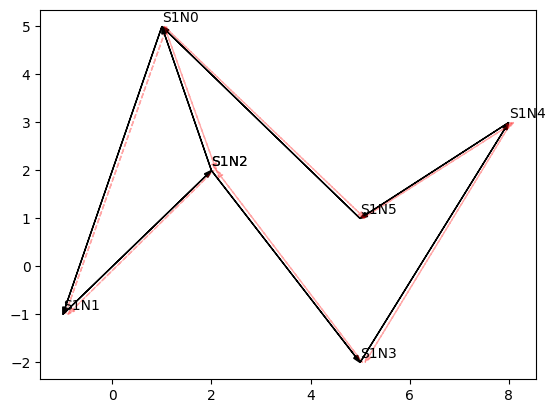

,name,origin,next,prev_edge,next_edge,twin,prev_edge_twin,next_edge_twin,incident_face
0,SE0,S1N0,S1N1,SE6,SE1,SE0'',SE1'',SE5'',S1:F0
1,SE1,S1N1,S1N2,SE0,SE6,SE1'',SE2'',SE0'',S1:F0
2,SE2,S1N2,S1N3,SE6'',SE3,SE2'',SE3'',SE1'',S1:F1
3,SE3,S1N3,S1N4,SE2,SE4,SE3'',SE4'',SE2'',S1:F1
4,SE4,S1N4,S1N5,SE3,SE5,SE4'',SE5'',SE3'',S1:F1
5,SE5,S1N5,S1N0,SE4,SE6'',SE5'',SE0'',SE4'',S1:F1
6,SE6,S1N2,S1N0,SE1,SE0,SE6'',SE5,SE2,S1:F0


In [21]:
semiedges.add_new_edge(diagonals[0])

PlotDoubleConnectedEdgeList.plot(semiedges)
PlotDoubleConnectedEdgeList.show()
semiedges.show_data_structure()

# Ex. 2 

In [25]:
points1 = [np.array([13, 13]), np.array([11, 15]), np.array([8, 6]),
           np.array([9, 1]), np.array([12, 1])]
vectors1 = Vector.cast_to_vector(*points1)

semiedges1 = SemiEdgeList(vectors1, name = "S1")

count:  0
Processing start vertex
Diagonals: []
Status tree: [Node(11.000001904762811)]
Segments: [SE1]

count:  1
Processing regular vertex
Diagonals: []
Status tree: [Node(10.333334920635675)]
Segments: [SE1]

count:  2
Processing regular vertex
Interior is to the right
Diagonals: []
Status tree: [Node(7.999999714285795)]
Segments: [SE2]

count:  3
Processing regular vertex
Interior is to the right
Diagonals: []
Status tree: [Node(6.999999999999998)]
Segments: [SE3]

count:  4
Processing end vertex
Diagonals: []
Status tree: []
Segments: []



/tmp/ipykernel_4038/3627717471.py:143: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(direction)


/tmp/ipykernel_4038/3627717471.py:143: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(direction)


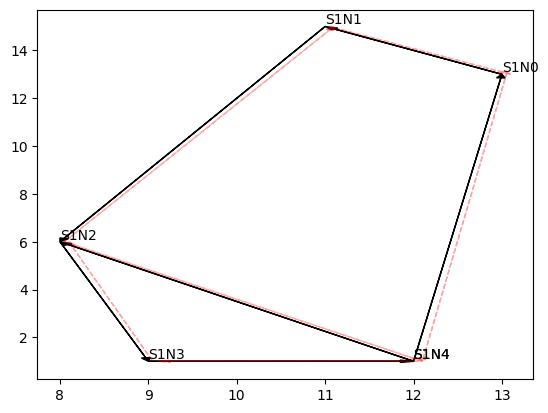

,name,origin,next,prev_edge,next_edge,twin,prev_edge_twin,next_edge_twin,incident_face
0,SE0,S1N0,S1N1,SE4,SE1,SE0'',SE1'',SE4'',S1:F0
1,SE1,S1N1,S1N2,SE0,SE5'',SE1'',SE2'',SE0'',S1:F0
2,SE2,S1N2,S1N3,SE5,SE3,SE2'',SE3'',SE1'',S1:F1
3,SE3,S1N3,S1N4,SE2,SE5,SE3'',SE4'',SE2'',S1:F1
4,SE4,S1N4,S1N0,SE5'',SE0,SE4'',SE0'',SE3'',S1:F0
5,SE5,S1N4,S1N2,SE3,SE2,SE5'',SE1,SE4,S1:F1


In [29]:
edge = SemiEdge(vectors1[-1], vectors1[2], need_cast=True)
semiedges1.add_new_edge(edge)

PlotDoubleConnectedEdgeList.plot(semiedges1)
PlotDoubleConnectedEdgeList.show()
semiedges1.show_data_structure()

As you can verify the output is the updated list of semiedges, indeed with the operation ***add_new_edge*** we modify the SemiEdgeList class in place, pretty similar to what .append() method would do on a classical list. 

And with the drawing along with the printed table you can further check the correctes of the insertion.